### German Text Classification - Coding Challenge 

Project Outline :

1. Data Import 
2. Cleaning & EDA
3. Visualization 
4. Data Preprocessing 
5. Model Selection 
6. ML Pipeline Building 
7. Future Work/Conclusion 

In [2]:
#Importing the necessary libraries 

#Basic Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

#Text Processing related libraries
import re
import string
import math
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from HanTa import HanoverTagger as ht
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#Model Building related libraries
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from sklearn import feature_selection
from sklearn.pipeline import Pipeline

#Model Dump/Load related libraries
import joblib
from joblib import dump
from joblib import load

## Data Import

In [2]:
#Read the file into a DataFrame: data
data = pd.read_csv('sample_data.csv')

In [3]:
data.head(5) 

,text,label
0,zucker fabrik,ft
1,Lebensmittel kommssionierung,ft
2,geländer biegen,mr
3,gebäudeausrüstung technische,ct
4,kürbiskernöl softgels,ft


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37295 entries, 0 to 37294
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    37295 non-null  object
 1   label   37195 non-null  object
dtypes: object(2)
memory usage: 582.9+ KB


## Data Cleaning 

* Removing rows with no labels since they are not useful for the analysis

In [5]:
print("No of rows with no labels:", data['label'].isnull().sum(),"\n")

data_clean_1 = data.dropna(axis=0).copy()
data_clean_1.info()

No of rows with no labels: 100 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37195 entries, 0 to 37294
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    37195 non-null  object
 1   label   37195 non-null  object
dtypes: object(2)
memory usage: 871.8+ KB


* Removing text corresponding to email addresses

In [6]:
x=data_clean_1[data_clean_1['text'].str.contains('@')]['text'] #Data set specific cleaning
data_clean_1 = data_clean_1[data_clean_1.text.isin(x)==False]

In [7]:
#Waterfall count check
print(data_clean_1['text'].count(),len(x))

36895 300


* Removing any characters other than alphabets 

In [8]:
data_clean_1['text']=data_clean_1['text'].apply(lambda x : re.sub(r"[^A-Za-zäöüÄÖÜß \t]", " ", x))

* Checking for text column which contains only spaces or one letter texts and removing the corresponding rows

In [9]:
data_clean_1['len'] = data_clean_1['text'].apply(lambda x : len(x) - x.count(" "))#No of characters in the text excluding space
x= data_clean_1[data_clean_1['len']<2]['text']

print("No of rows with one letter or less ",len(x))

data_clean_2 = data_clean_1[['text','label']][data_clean_1.text.isin(x)==False].copy()

print("Waterfall count check ",data_clean_1['text'].count()-data_clean_2['text'].count())

No of rows with one letter or less  1008
Waterfall count check  1008


In [10]:
#Resetting the index 
data_clean_2.reset_index(inplace=True)
data_clean_2.drop(columns=['index'],inplace=True)

In [11]:
data_clean_2.head()

,text,label
0,zucker fabrik,ft
1,Lebensmittel kommssionierung,ft
2,geländer biegen,mr
3,gebäudeausrüstung technische,ct
4,kürbiskernöl softgels,ft


* Normalizing the text

In [12]:
data_clean_2['text'] = data_clean_2['text'].apply(lambda x: x.lower())

* Removing Stop words and lemmatization

In [13]:
#Loading the stop words in german
stop_words = set(stopwords.words('german'))
stop_words.add("fuer")
substring = "fräs"
#Converting text to word tokens
word_tokens = []
for i in data_clean_2.index:
    word_tokens.append(nltk.tokenize.WordPunctTokenizer().tokenize(data_clean_2.text[i]))

#Using Hanover Tagger for lemmatization of each word  
tagger = ht.HanoverTagger('morphmodel_ger.pgz')
filtered_sentence = []
for i in data_clean_2.index:
    temp = []
    for w in word_tokens[i]:
        if w not in stop_words: #Removing stop words
            temp.append(tagger.analyze(w)[0]) #The method analyze gives the lemma of a word.
    filtered_sentence.append(temp)

    
text =[' '.join(i) for i in filtered_sentence] #Converting to a single list
print("Row Count Check: \nBefore:",len(text)," After: ",data_clean_2['text'].count())

Row Count Check: 
Before: 35887  After:  35887


In [14]:
data_clean_3 = data_clean_2.copy()
data_clean_3['text'] = text
data_clean_3['text'] = data_clean_3['text'].apply(lambda x: x.lower())

In [15]:
data_clean = data_clean_3.copy()
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    35887 non-null  object
 1   label   35887 non-null  object
dtypes: object(2)
memory usage: 560.9+ KB


## Data Visualisation

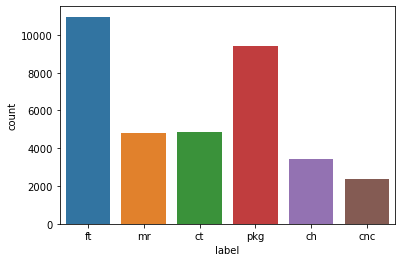

In [16]:
sns.countplot(x="label", data=data_clean)
plt.show()

In [17]:
#Data Specific Cleaning 
substring = "fräs"
word_tokens = []
for i in data_clean.index:
    word_tokens.append(nltk.tokenize.WordPunctTokenizer().tokenize(data_clean.text[i]))

    
filtered_sentence = []
for i in data_clean.index:
    temp = []
    for w in word_tokens[i]:
        if substring in w:
            w="fräsen"
        temp.append(w)
    filtered_sentence.append(temp)
    
text =[' '.join(i) for i in filtered_sentence]
data_clean['text']=text

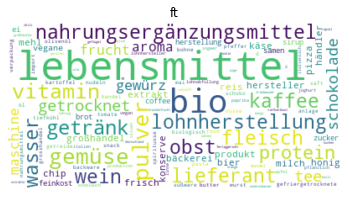

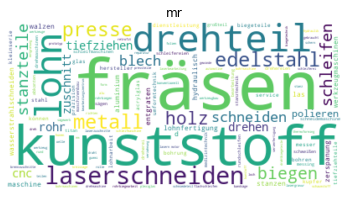

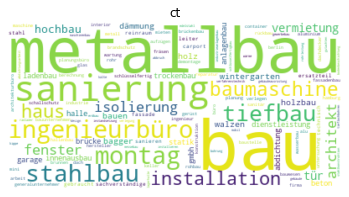

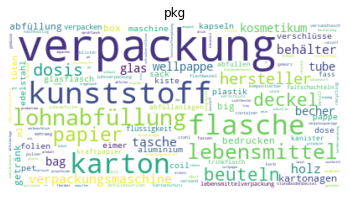

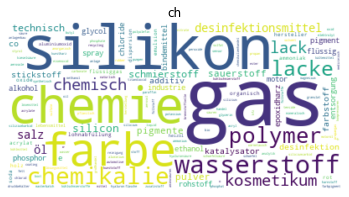

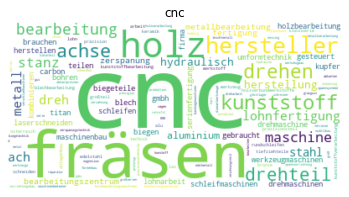

In [18]:
labels = data_clean['label'].unique()
for i in labels:
    ft_data = data_clean[data_clean['label']==i]['text']
    #Convert to string of words for each label
    ft_data=ft_data.to_string()
    #Generate Word Cloud
    word_cloud = WordCloud(collocations = False, background_color = 'white').generate(ft_data)
    # Display the generated Word Cloud
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(i)
    plt.show()

## Data Test-Validation Split

In [63]:
# split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(data_clean['text'], data_clean['label'])#Default = 25%

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

#Checking the label encoded values
mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(mapping)


## Feature Extraction

<b> 1. Bag of Words </b>

In [65]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w+')#Matches one or more word characters
count_vect.fit(train_x)


CountVectorizer(token_pattern='\\w+')

<b> Feature Selection for Bag of Words </b> <br>

Since we have many features, it is good to do some feature selection. This is done using the Chi Square test. It tests whether the label is independent of the text input. If so, they are eliminated using the p values.
This way, the dimentions of the feature matrix is reduced.

In [66]:
print("No of features before reduction: ",len(count_vect.get_feature_names()))

No of features before reduction:  14749


In [67]:

X_features = count_vect.get_feature_names()
y = train_y
p_value_limit = 0.05
selected_features = pd.DataFrame()
xtrain_count =  count_vect.transform(train_x)#Get the count vector

for i in np.unique(train_y):
    chi2, p = feature_selection.chi2(xtrain_count, y==i)#Performing the chi square test
    
    selected_features = selected_features.append(pd.DataFrame(
                   {"feature":X_features, "score":p, "y":i}))
    selected_features = selected_features.sort_values(["y","score"], 
                    ascending=[True,False])
    
    selected_features = selected_features[selected_features["score"]<p_value_limit]#Selecting features based on alpha=0.05
    
X_features = selected_features["feature"].unique().tolist()

print("No of features after reduction: ",len(X_features))


No of features after reduction:  8904


Now, we shall refit the vectorizer on the new set of words as input. This results in a smaller feature set.

In [68]:
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w+',vocabulary=X_features)#limit to the significant features
count_vect.fit(train_x)

# transform the training and validation data using count vectorizer object
xtrain_count =  count_vect.transform(train_x)
xvalid_count =  count_vect.transform(valid_x)

<b> Word Level TF-IDF </b>

In [69]:

tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w+')
tfidf_vect.fit(train_x)

xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)


## Model Selection

In [70]:
def train_model(model, x_train, y_train, x_test):
    # fit the training dataset 
    model.fit(x_train, y_train)
    
    # predict the labels on validation dataset
    predictions = model.predict(x_test)
    
    return predictions

<b> Naive Bayes on Count Vectors </b>

Model Accuracy:
0.8859786000891663 

Model Summary Report:
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       852
           1       0.85      0.74      0.79       599
           2       0.95      0.91      0.93      1270
           3       0.87      0.95      0.91      2738
           4       0.86      0.82      0.84      1224
           5       0.87      0.89      0.88      2289

    accuracy                           0.89      8972
   macro avg       0.89      0.86      0.87      8972
weighted avg       0.89      0.89      0.89      8972

Confusion Matrix:


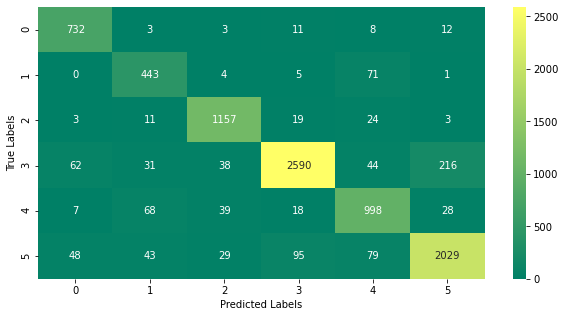

{'ch': 0, 'cnc': 1, 'ct': 2, 'ft': 3, 'mr': 4, 'pkg': 5}


In [71]:

nbc = naive_bayes.MultinomialNB()
predictions = train_model(nbc,xtrain_count, train_y,xvalid_count)

print("Model Accuracy:")
print(metrics.accuracy_score(predictions, valid_y),"\n")

print("Model Summary Report:")
print(metrics.classification_report(valid_y, predictions))

print("Confusion Matrix:")
plt.figure(figsize = (10,5))
sns.heatmap(metrics.confusion_matrix(predictions, valid_y), annot=True, fmt='d', \
            xticklabels = np.unique(predictions), yticklabels = np.unique(predictions), cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
print(mapping)

<b> Naive Bayes on TF-IDF Vectors </b>

Model Accuracy:
0.8681453410610789 

Model Summary Report:
              precision    recall  f1-score   support

           0       0.97      0.76      0.85       852
           1       0.89      0.57      0.69       599
           2       0.95      0.89      0.92      1270
           3       0.85      0.95      0.90      2738
           4       0.81      0.82      0.82      1224
           5       0.84      0.90      0.87      2289

    accuracy                           0.87      8972
   macro avg       0.89      0.81      0.84      8972
weighted avg       0.87      0.87      0.87      8972

Confusion Matrix:


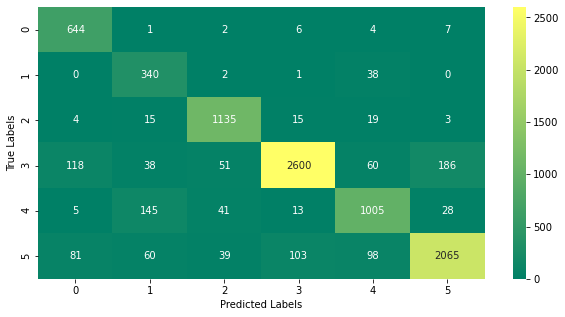

{'ch': 0, 'cnc': 1, 'ct': 2, 'ft': 3, 'mr': 4, 'pkg': 5}


In [72]:

nbc = naive_bayes.MultinomialNB()
predictions = train_model(nbc,xtrain_tfidf, train_y,xvalid_tfidf)

print("Model Accuracy:")
print(metrics.accuracy_score(predictions, valid_y),"\n")

print("Model Summary Report:")
print(metrics.classification_report(valid_y, predictions))

print("Confusion Matrix:")
plt.figure(figsize = (10,5))
sns.heatmap(metrics.confusion_matrix(predictions, valid_y), annot=True, fmt='d', \
            xticklabels = np.unique(predictions), yticklabels = np.unique(predictions), cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
print(mapping)

<b> Random Forest Classifier on Count Vectors </b>

Model Accuracy:
0.8808515381185912 

Model Summary Report:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       852
           1       0.90      0.76      0.82       599
           2       0.97      0.90      0.93      1270
           3       0.90      0.92      0.91      2738
           4       0.90      0.79      0.85      1224
           5       0.80      0.91      0.85      2289

    accuracy                           0.88      8972
   macro avg       0.90      0.86      0.87      8972
weighted avg       0.89      0.88      0.88      8972

Confusion Matrix:


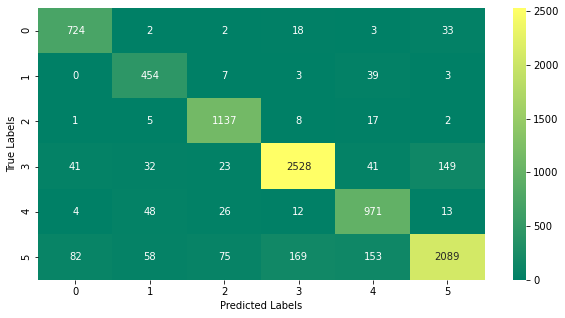

{'ch': 0, 'cnc': 1, 'ct': 2, 'ft': 3, 'mr': 4, 'pkg': 5}


In [73]:

rfc = ensemble.RandomForestClassifier()
predictions = train_model(rfc,xtrain_count, train_y,xvalid_count)

print("Model Accuracy:")
print(metrics.accuracy_score(predictions, valid_y),"\n")

print("Model Summary Report:")
print(metrics.classification_report(valid_y, predictions))

print("Confusion Matrix:")
plt.figure(figsize = (10,5))
sns.heatmap(metrics.confusion_matrix(predictions, valid_y), annot=True, fmt='d', \
            xticklabels = np.unique(predictions), yticklabels = np.unique(predictions), cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
print(mapping)


<b> Random Forest Classifier on TF-IDF Vectors </b>

Model Accuracy:
0.8730494872938029 

Model Summary Report:
              precision    recall  f1-score   support

           0       0.94      0.85      0.89       852
           1       0.85      0.77      0.81       599
           2       0.96      0.87      0.91      1270
           3       0.81      0.96      0.88      2738
           4       0.85      0.81      0.83      1224
           5       0.91      0.84      0.88      2289

    accuracy                           0.87      8972
   macro avg       0.89      0.85      0.87      8972
weighted avg       0.88      0.87      0.87      8972

Confusion Matrix:


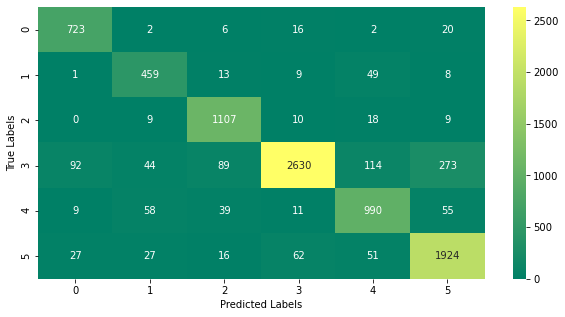

{'ch': 0, 'cnc': 1, 'ct': 2, 'ft': 3, 'mr': 4, 'pkg': 5}


In [74]:

rfc = ensemble.RandomForestClassifier()
predictions = train_model(rfc,xtrain_tfidf, train_y,xvalid_tfidf)

print("Model Accuracy:")
print(metrics.accuracy_score(predictions, valid_y),"\n")

print("Model Summary Report:")
print(metrics.classification_report(valid_y, predictions))

print("Confusion Matrix:")
plt.figure(figsize = (10,5))
sns.heatmap(metrics.confusion_matrix(predictions, valid_y), annot=True, fmt='d', \
            xticklabels = np.unique(predictions), yticklabels = np.unique(predictions), cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
print(mapping)


<b> Support Vector Classifier on Count Vectors </b>

Model Accuracy:
0.8876504681230495 

Model Summary Report:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       852
           1       0.88      0.75      0.81       599
           2       0.96      0.91      0.93      1270
           3       0.84      0.96      0.90      2738
           4       0.89      0.82      0.85      1224
           5       0.90      0.88      0.89      2289

    accuracy                           0.89      8972
   macro avg       0.90      0.86      0.88      8972
weighted avg       0.89      0.89      0.89      8972

Confusion Matrix:


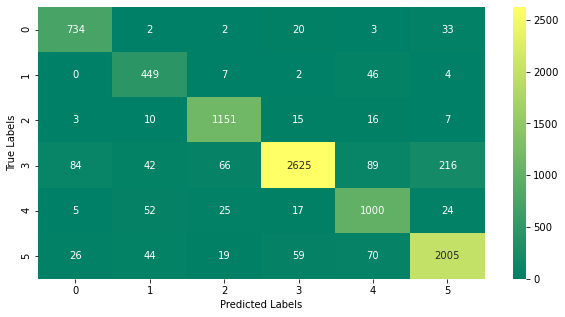

{'ch': 0, 'cnc': 1, 'ct': 2, 'ft': 3, 'mr': 4, 'pkg': 5}


In [75]:
svc = svm.SVC()
predictions = train_model(svc,xtrain_count, train_y,xvalid_count)

print("Model Accuracy:")
print(metrics.accuracy_score(predictions, valid_y),"\n")

print("Model Summary Report:")
print(metrics.classification_report(valid_y, predictions))

print("Confusion Matrix:")
plt.figure(figsize = (10,5))
sns.heatmap(metrics.confusion_matrix(predictions, valid_y), annot=True, fmt='d', \
            xticklabels = np.unique(predictions), yticklabels = np.unique(predictions), cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
print(mapping)


<b> Support Vector Classifier on TF-IDF Vectors </b>

Model Accuracy:
0.9009139545251895 

Model Summary Report:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       852
           1       0.88      0.75      0.81       599
           2       0.96      0.93      0.94      1270
           3       0.88      0.96      0.92      2738
           4       0.88      0.83      0.86      1224
           5       0.91      0.90      0.90      2289

    accuracy                           0.90      8972
   macro avg       0.91      0.87      0.89      8972
weighted avg       0.90      0.90      0.90      8972

Confusion Matrix:


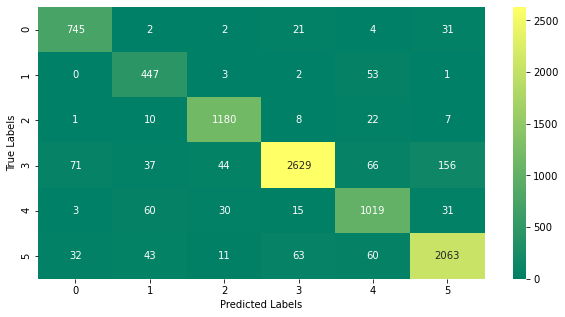

{'ch': 0, 'cnc': 1, 'ct': 2, 'ft': 3, 'mr': 4, 'pkg': 5}


In [76]:
svc = svm.SVC()
predictions = train_model(svc,xtrain_tfidf, train_y,xvalid_tfidf)

print("Model Accuracy:")
print(metrics.accuracy_score(predictions, valid_y),"\n")

print("Model Summary Report:")
print(metrics.classification_report(valid_y, predictions))

print("Confusion Matrix:")
plt.figure(figsize = (10,5))
sns.heatmap(metrics.confusion_matrix(predictions, valid_y), annot=True, fmt='d', \
            xticklabels = np.unique(predictions), yticklabels = np.unique(predictions), cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
print(mapping)


Overall, the Support Vector Classifier with TF-IDF performs relatively better than the other models. Hence, we will choose the above model.

## Model Deployment

<b> Indeally, the model should be trained on the complete dataset. However, for testing purposes I have limited to only training data.

In [77]:

# define the stages of the pipeline
pipeline = Pipeline(steps= [('tfidf_vect', TfidfVectorizer(analyzer='word', token_pattern=r'\w+')),
                            ('model', svm.SVC())])

# fit the pipeline model                         
pipeline.fit(train_x, train_y)


Pipeline(steps=[('tfidf_vect', TfidfVectorizer(token_pattern='\\w+')),
                ('model', SVC())])

In [78]:
# dump the pipeline model
dump(pipeline, filename="final_model.joblib")

['final_model.joblib']

<b> Testing </b> 

In [80]:
model = load("final_model.joblib")

In [109]:
labels=list(mapping.keys())

In [114]:
labels

['ch', 'cnc', 'ct', 'ft', 'mr', 'pkg']

In [111]:
print(labels[int(model.predict(["lohnabfüllung iso getränk"]))])
print(data_clean[data_clean.text == "lohnabfüllung iso getränk"])

pkg
                            text label
29486  lohnabfüllung iso getränk   pkg


In [113]:
print(labels[int(model.predict(["rundschleifen cnc drehen"]))])
print(data_clean[data_clean.text == "rundschleifen cnc drehen"])

cnc
                           text label
26808  rundschleifen cnc drehen   cnc


## Future Work/Conclusion

1. Hyperparameter tuning for models and tweaking of existing feature selection methods.
2. Develop a neural network model and incorporate word embeddings. 
3. Adding more information to the dataset itself. For example, add images (if feasible) to enhance the prediction capability.
4. Further understanding of data - which will inturn help in the cleaning process.
5. app.py (API Code) - Screening of the input from the user should be done. For example, if the user inputs only numbers /special characters - "Invalid Input" message to be displayed. 

### German Stemmer 

Although SnowballStemmer exists for German text. However, more research needs to be done for better results. Hence, i have excluded the below step from the analysis due to time constraints.

In [ ]:
from nltk.stem.snowball import SnowballStemmer

snowball = SnowballStemmer("german")

word = 'machen'

print ('Snowball: ' + snowball.stem(word))

### Word Embeddings

The below code creates the embedding matrix from a pre-trained german word embedding file. Ideally, the next step would be to use the embedding matrix as a embedding layer to the Neural Network model.

In [ ]:
# load the pre-trained word-embedding vectors 
embeddings_index = {}
x=open('cc.de.300.vec',encoding="utf8")#Pre trained file from Fasttext
for i, line in enumerate(x):
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')

#Converting text to word tokens
word_tokens = []
for i in data_clean.index:
    word_tokens.append(nltk.tokenize.WordPunctTokenizer().tokenize(data_clean.text[i]))

data = []
for i in data_clean.index:
    for w in word_tokens[i]:
        data.append(w) 

# create token-embedding mapping
embedding_matrix = np.zeros((len(data) + 1, 300))
i=0
for word in data:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        i=i+1